In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from constant import AFFECTNETPATH

In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file,base_path,transform=None):
        self.fields = ['subDirectory_filePath', 'expression','valence','arousal']
        self._table = pd.read_csv(csv_file,usecols=self.fields)
        
        self._table=self._table[self._table['expression'] <8]

        self._table=self._table.reset_index(drop=True)

        self._base_path=base_path
   



        self.transform=transforms.Compose([
                     transforms.Resize((64,64)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])

    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path,self._table.subDirectory_filePath[idx])
        img=Image.open(folder_name)
        img=self.transform(img)
        valence = torch.from_numpy(np.array(self._table.valence[idx]))
        return (img,valence.float())
            
        

In [3]:
Affect_Train=ImageDataset('training.csv',AFFECTNETPATH)
Affect_Valid=ImageDataset('validation.csv',AFFECTNETPATH)

In [4]:
import csv
def import_data(filename):
    """Import data in the second column of the supplied filename as floats."""
    with open(filename, 'r') as inf:
        inf.readline()
        return [float(row[2]) for row in csv.reader(inf)]

In [5]:
len(Affect_Train)

287652

In [6]:
train_dataloader = DataLoader(Affect_Train, batch_size=256
                       , num_workers=0,shuffle=True)

valid_dataloader = DataLoader(Affect_Valid, batch_size=256
                       , num_workers=0)    

In [7]:
len(train_dataloader)

1124

In [8]:
import torchvision.models as models

resnet50 = models.resnet50(pretrained=True)


for name, child in resnet50.named_children():
    if not name in ['fc']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
               param.requires_grad = False
                
                

conv1 is unfrozen
bn1 is unfrozen
relu is unfrozen
maxpool is unfrozen
layer1 is unfrozen
layer2 is unfrozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is unfrozen
fc is frozen


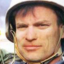

In [9]:
img=transforms.ToPILImage()(Affect_Train[26][0]*0.5+0.5)
img


In [10]:
from module import face_feature

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

model=face_feature.Face_Feature(resnet50)


model=model.to(device)

In [12]:
device

device(type='cuda', index=0)

In [13]:
#from torchsummary import summary
#summary(model,(3,64,64))

In [14]:
model(Affect_Train[0][0].unsqueeze(0).to(device))

tensor([[-0.0127]], grad_fn=<AddmmBackward>)

In [15]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005, betas=(0.5, 0.999))

In [16]:
from tqdm.notebook import tqdm

In [17]:
len(train_dataloader)

1124

In [18]:
train_loss=[]
val_loss=[]
num_epochs=50

for epochs in (range(0,num_epochs)):
    model.train()
    print("Training Epoch: ", epochs+1,"\n")
   
    for i_batch, (img,valence) in tqdm(enumerate(train_dataloader)):
        batch_size=img.size(0)
        optimizer.zero_grad()
        img=img.to(device)
        val_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        loss=loss1
        loss.backward()
        optimizer.step()
        if i_batch%500==0:
            print("Batch: ",i_batch+1,"/",len(train_dataloader))
            print("MSE loss: ", loss.item())
            train_loss.append(loss.item())
    model.eval()
    avg_loss=1e-6
    temp_loss=0
    for i_batch, (img,valence) in enumerate(valid_dataloader):
        
        batch_size=img.size(0)

        img=img.to(device)
        val_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        #loss2=loss_func(arou_output,valence.to(device))
        loss=loss1
        temp_loss+=loss.item()
    print("ValidationLoss: ",temp_loss/len(valid_dataloader))
    val_loss.append(temp_loss/len(valid_dataloader))
    if temp_loss<avg_loss:
        avg_loss=temp_loss
        torch.save(model,"face_feature.h")
    

    

    
        

Training Epoch:  1 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:  1 / 1124
MSE loss:  0.6562232971191406
Batch:  501 / 1124
MSE loss:  0.2707501947879791
Batch:  1001 / 1124
MSE loss:  0.27651673555374146


/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([164])) that is different to the input size (torch.Size([164, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



ValidationLoss:  0.354273421689868
Training Epoch:  2 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:  1 / 1124
MSE loss:  0.25114816427230835
Batch:  501 / 1124
MSE loss:  0.26549243927001953
Batch:  1001 / 1124
MSE loss:  0.2554183602333069

ValidationLoss:  0.37740706093609333
Training Epoch:  3 



Batch:  1 / 1124
MSE loss:  0.27072155475616455
Batch:  501 / 1124
MSE loss:  0.28636491298675537
Batch:  1001 / 1124
MSE loss:  0.24151703715324402

ValidationLoss:  0.36686808057129383
Training Epoch:  4 



Batch:  1 / 1124
MSE loss:  0.2951001822948456
Batch:  501 / 1124
MSE loss:  0.3019934296607971
Batch:  1001 / 1124
MSE loss:  0.25588729977607727

ValidationLoss:  0.36420826241374016
Training Epoch:  5 



Batch:  1 / 1124
MSE loss:  0.2528102993965149
Batch:  501 / 1124
MSE loss:  0.266925185918808
Batch:  1001 / 1124
MSE loss:  0.2514961361885071

ValidationLoss:  0.36722514778375626
Training Epoch:  6 



Batch:  1 / 1124
MSE loss:  0.2961079478263855
Batch:  501 / 1124
MSE loss:  0.2495526373386383
Batch:  1001 / 1124
MSE loss:  0.26675963401794434

ValidationLoss:  0.36553324572741985
Training Epoch:  7 



Batch:  1 / 1124
MSE loss:  0.27516287565231323
Batch:  501 / 1124
MSE loss:  0.2609800100326538
Batch:  1001 / 1124
MSE loss:  0.27851369976997375

ValidationLoss:  0.35625235736370087
Training Epoch:  8 



Batch:  1 / 1124
MSE loss:  0.2434932291507721
Batch:  501 / 1124
MSE loss:  0.2683630883693695
Batch:  1001 / 1124
MSE loss:  0.27132168412208557

ValidationLoss:  0.36471219547092915
Training Epoch:  9 



Batch:  1 / 1124
MSE loss:  0.2734159231185913
Batch:  501 / 1124
MSE loss:  0.2668251395225525
Batch:  1001 / 1124
MSE loss:  0.2720189690589905

ValidationLoss:  0.3645400460809469
Training Epoch:  10 



Batch:  1 / 1124
MSE loss:  0.2670469284057617
Batch:  501 / 1124
MSE loss:  0.27260562777519226
Batch:  1001 / 1124
MSE loss:  0.2606423795223236

ValidationLoss:  0.364826463162899
Training Epoch:  11 



Batch:  1 / 1124
MSE loss:  0.2642790973186493
Batch:  501 / 1124
MSE loss:  0.3240172266960144
Batch:  1001 / 1124
MSE loss:  0.27602827548980713

ValidationLoss:  0.33721084520220757
Training Epoch:  12 



Batch:  1 / 1124
MSE loss:  0.26329201459884644
Batch:  501 / 1124
MSE loss:  0.25678446888923645
Batch:  1001 / 1124
MSE loss:  0.2588239312171936

ValidationLoss:  0.3753490727394819
Training Epoch:  13 



Batch:  1 / 1124
MSE loss:  0.30447399616241455
Batch:  501 / 1124
MSE loss:  0.36595025658607483
Batch:  1001 / 1124
MSE loss:  0.2743885815143585

ValidationLoss:  0.4027554653584957
Training Epoch:  14 



Batch:  1 / 1124
MSE loss:  0.2534482777118683
Batch:  501 / 1124
MSE loss:  0.2762872874736786
Batch:  1001 / 1124
MSE loss:  0.3184758424758911

ValidationLoss:  0.2824061904102564
Training Epoch:  15 



Batch:  1 / 1124
MSE loss:  0.3103925585746765
Batch:  501 / 1124
MSE loss:  0.3104032278060913
Batch:  1001 / 1124
MSE loss:  0.2648758590221405

ValidationLoss:  0.2908130995929241
Training Epoch:  16 



Batch:  1 / 1124
MSE loss:  0.2926445007324219
Batch:  501 / 1124
MSE loss:  0.31372982263565063
Batch:  1001 / 1124
MSE loss:  0.3089950382709503

ValidationLoss:  0.34715803898870945
Training Epoch:  17 



Batch:  1 / 1124
MSE loss:  0.25031232833862305
Batch:  501 / 1124
MSE loss:  0.2848026752471924
Batch:  1001 / 1124
MSE loss:  0.2530820965766907

ValidationLoss:  0.23727433755993843
Training Epoch:  18 



Batch:  1 / 1124
MSE loss:  0.3340734541416168
Batch:  501 / 1124
MSE loss:  0.30260807275772095
Batch:  1001 / 1124
MSE loss:  0.3104369640350342

ValidationLoss:  0.3666126299649477
Training Epoch:  19 



Batch:  1 / 1124
MSE loss:  0.2957155108451843
Batch:  501 / 1124
MSE loss:  0.2602013349533081
Batch:  1001 / 1124
MSE loss:  0.2489422857761383

ValidationLoss:  0.2623277548700571
Training Epoch:  20 



Batch:  1 / 1124
MSE loss:  0.3069378733634949
Batch:  501 / 1124
MSE loss:  0.26667821407318115
Batch:  1001 / 1124
MSE loss:  0.24943813681602478

ValidationLoss:  0.33478505350649357
Training Epoch:  21 



Batch:  1 / 1124
MSE loss:  0.25262659788131714
Batch:  501 / 1124
MSE loss:  0.2630021274089813
Batch:  1001 / 1124
MSE loss:  0.2559962272644043

ValidationLoss:  0.3648155890405178
Training Epoch:  22 



Batch:  1 / 1124
MSE loss:  0.26780956983566284
Batch:  501 / 1124
MSE loss:  0.23592591285705566
Batch:  1001 / 1124
MSE loss:  0.27050912380218506

ValidationLoss:  0.36943567357957363
Training Epoch:  23 



Batch:  1 / 1124
MSE loss:  0.27647852897644043
Batch:  501 / 1124
MSE loss:  0.2615661025047302
Batch:  1001 / 1124
MSE loss:  0.2498762458562851

ValidationLoss:  0.3576318435370922
Training Epoch:  24 



Batch:  1 / 1124
MSE loss:  0.23995518684387207
Batch:  501 / 1124
MSE loss:  0.2302553355693817
Batch:  1001 / 1124
MSE loss:  0.2679920494556427

ValidationLoss:  0.36649509333074093
Training Epoch:  25 



Batch:  1 / 1124
MSE loss:  0.27374154329299927
Batch:  501 / 1124
MSE loss:  0.2839738428592682
Batch:  1001 / 1124
MSE loss:  0.2383246123790741

ValidationLoss:  0.3682795334607363
Training Epoch:  26 



Batch:  1 / 1124
MSE loss:  0.26883113384246826
Batch:  501 / 1124
MSE loss:  0.2976784110069275
Batch:  1001 / 1124
MSE loss:  0.3040613532066345

ValidationLoss:  0.3726897109299898
Training Epoch:  27 



Batch:  1 / 1124
MSE loss:  0.2806326150894165
Batch:  501 / 1124
MSE loss:  0.26180797815322876
Batch:  1001 / 1124
MSE loss:  0.2882651090621948

ValidationLoss:  0.35799469240009785
Training Epoch:  28 



Batch:  1 / 1124
MSE loss:  0.22606639564037323
Batch:  501 / 1124
MSE loss:  0.2604140639305115
Batch:  1001 / 1124
MSE loss:  0.24370351433753967

ValidationLoss:  0.36248551309108734
Training Epoch:  29 



Batch:  1 / 1124
MSE loss:  0.2809601426124573
Batch:  501 / 1124
MSE loss:  0.26312050223350525
Batch:  1001 / 1124
MSE loss:  0.24789398908615112

ValidationLoss:  0.3725569285452366
Training Epoch:  30 



Batch:  1 / 1124
MSE loss:  0.26163798570632935
Batch:  501 / 1124
MSE loss:  0.27414828538894653
Batch:  1001 / 1124
MSE loss:  0.2713739275932312

ValidationLoss:  0.2915320210158825
Training Epoch:  31 



Batch:  1 / 1124
MSE loss:  0.278652548789978
Batch:  501 / 1124
MSE loss:  0.2920314073562622


KeyboardInterrupt: 

In [24]:
torch.save(model.resnet,"pre_trained_resnet.h")

/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won'

In [25]:
torch.save(model.resnet.state_dict(), "pretrained_state_dict")

In [ ]:
print("hu")

In [23]:
model

Face_Feature(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      